Comparing our Fluxbot data to CIRAS data collected at the "same" time

1. Load the CIRAS data
1. Load the Fluxbots
1. Find the closest event for each CIRAS data.

In [31]:
import pandas as pd
import numpy as np
import glob
import random
import matplotlib.pyplot as plot

## Step 1: Load up the CIRAS data and create a timestamp column

In [7]:
# Get all the CIRAS data
# NOTE: This does not include the `dblchk` files..
ciras_dir = 'data/calval'
file = ciras_dir + '/calval_CIRASdat_Jan21.csv'

In [8]:
ciras_df = pd.read_csv(file)

In [9]:
ciras_df.columns

Index(['PLOT', 'TRTMNT', 'FEAT', 'BOTREP', 'BOTID', 'CIRASFLX_L', 'CIRASFLX_Q',
       'CIRAS_T'],
      dtype='object')

In [11]:
# ciras_df['timestamp'] = pd.to_datetime(df.CIRAS_T)
ciras_df['timestamp'] = pd.to_datetime(ciras_df.CIRAS_T)

ciras_df.head()

,PLOT,TRTMNT,FEAT,BOTREP,BOTID,CIRASFLX_L,CIRASFLX_Q,CIRAS_T,timestamp
0,N,O,OM,2,NO OM 2,2.55,2.47,8/17/19 10:34,2019-08-17 10:34:00
1,N,MWC,OM,1,NMWC OM 1,3.47,3.07,8/15/19 12:05,2019-08-15 12:05:00
2,N,MWC,OM,1,NMWC OM 1,4.03,3.62,8/13/19 12:01,2019-08-13 12:01:00
3,N,O,OM,2,NO OM 2,2.60,2.50,8/20/19 10:36,2019-08-20 10:36:00
4,N,O,UT,1,NO UT 1,1.81,1.36,8/13/19 12:53,2019-08-13 12:53:00


## Helper Functions to Read Data and Determine the "Closest" fluxbot observation

In [24]:
def float_conv(x):
    try:
        return float(x)
    except:
        return np.nan

locations = {
    'OM': 'Termite Soil',
    'UT': 'Under Tree',
    'OS': 'Open Soil'
}

# def find_closest(ciras, fluxbots):
#     this_treatment = ciras.TRTMNT
#     this_location = locations[ciras.FEAT]
#     this_replicate = ciras.BOTREP
#     df = fluxbots[
#         (fluxbots['treatment'] == this_treatment) & 
#         (fluxbots['location'] == this_feature) & 
#         (fluxbots['replicate'] == this_replicate)
#     ]
#     time_diffs = abs(df['timestamp'] - ciras.timestamp)
#     result = np.where(time_diffs == np.amin(time_diffs))
#     return df.iloc[result], np.amin(time_diffs)

def find_closest(ciras_df, event_df):
    this_treatment = ciras_df.TRTMNT
    this_location = locations[ciras_df.FEAT]
    this_replicate = ciras_df.BOTREP
    df = event_df[
        (event_df['treatment'] == this_treatment) & 
        (event_df['location'] == this_location) & 
        (event_df['replicate'] == this_replicate)
    ]
    time_diffs = abs(df['timestamp'] - ciras_df.timestamp)
    result = np.where(time_diffs == np.amin(time_diffs))
    return df.iloc[result], np.amin(time_diffs)


# Step 2: Load up all the fluxbot data.

In [20]:
event_file = 'data/all_events_with_bad_20.csv'
event_df = pd.read_csv(event_file, converters={
    'ambient_CO2_kg':float_conv,
    'ambient_CO2_ppm':float_conv,
    'flux_umol_m2_sec':float_conv,
    'flux_error_umol_m2_sec': float_conv
})
event_df['timestamp'] = pd.to_datetime(event_df['timestamp'])

## Merge the CIRAS data with the closest fluxbot observation.

In [25]:
# We will make a list of individual rows; each row is a dataframe that combines the CIRAS and the Fluxbot data.
joined_rows = []

# Iterate over each of the rows.
for i, row in ciras_df.iterrows():
    closest, dT = find_closest(row, event_df)
    closest = closest.reset_index()
    this_row = pd.DataFrame(row).T
    this_row = this_row.reset_index()
    this_obs = this_row.join(closest, how='outer', rsuffix='_fluxbot', lsuffix='_ciras')
    this_obs['delta_T'] = dT
    joined_rows.append(this_obs)

# calval_df = pd.concat([rows for rows in joined_rows])
calval_df_2 = pd.concat([rows for rows in joined_rows])

In [27]:
# calval_df.to_csv('data/ciras_fluxbot_calval.csv')
calval_df_2.to_csv('data/ciras_fluxbot_calval_2.csv')

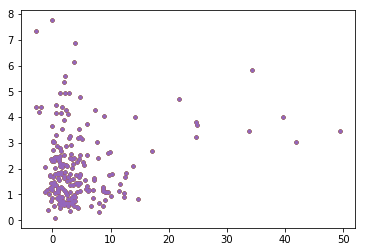

In [38]:
# plot.plot(calval_df['flux_umol_m2_sec'], calval_df['CIRASFLX_L'],'.')
plot.plot(calval_df_2['flux_umol_m2_sec'], calval_df_2['CIRASFLX_L'],'.')
plot.show()

In [33]:
calval_df_2


,index_ciras,PLOT,TRTMNT,FEAT,BOTREP,BOTID,CIRASFLX_L,CIRASFLX_Q,CIRAS_T,timestamp_ciras,...,flux_min_umol_m2_sec,qaqc_flags,datafile,chamber_volume_cm3,chamber_area_cm2,treatment,block,location,replicate,delta_T
0,0,N,O,OM,2,NO OM 2,2.55,2.47,8/17/19 10:34,2019-08-17 10:34:00,...,5.885,0,data/NO OM2.csv,2758,145.5,O,Northern,Termite Soil,2,00:21:21
0,1,N,MWC,OM,1,NMWC OM 1,3.47,3.07,8/15/19 12:05,2019-08-15 12:05:00,...,33.835,0,data/NMWC OM1.csv,2758,145.5,MWC,Northern,Termite Soil,1,00:09:39
0,2,N,MWC,OM,1,NMWC OM 1,4.03,3.62,8/13/19 12:01,2019-08-13 12:01:00,...,8.880,0,data/NMWC OM1.csv,2758,145.5,MWC,Northern,Termite Soil,1,00:04:42
0,3,N,O,OM,2,NO OM 2,2.6,2.5,8/20/19 10:36,2019-08-20 10:36:00,...,9.597,0,data/NO OM2.csv,2758,145.5,O,Northern,Termite Soil,2,00:19:21
0,4,N,O,UT,1,NO UT 1,1.81,1.36,8/13/19 12:53,2019-08-13 12:53:00,...,4.812,0,data/NO UT1.csv,2758,145.5,O,Northern,Under Tree,1,00:02:21
0,5,N,O,OM,1,NO OM 1,2.67,2.71,8/20/19 10:09,2019-08-20 10:09:00,...,1.438,0,data/NO OM1.csv,2758,145.5,O,Northern,Termite Soil,1,00:13:39
0,6,N,O,OM,2,NO OM 2,4.29,4.28,8/8/19 14:58,2019-08-08 14:58:00,...,7.384,0,data/NO OM2.csv,2758,145.5,O,Northern,Termite Soil,2,00:02:39
0,7,N,MWC,OM,1,NMWC OM 1,3.82,3.36,8/20/19 9:45,2019-08-20 09:45:00,...,24.751,0,data/NMWC OM1.csv,2758,145.5,MWC,Northern,Termite Soil,1,00:10:21
0,8,N,MWC,OM,1,NMWC OM 1,3.04,2.8,8/9/19 14:46,2019-08-09 14:46:00,...,41.798,0,data/NMWC OM1.csv,2758,145.5,MWC,Northern,Termite Soil,1,00:09:21
0,9,N,O,OM,2,NO OM 2,3.23,3.09,8/14/19 10:55,2019-08-14 10:55:00,...,4.722,0,data/NO OM2.csv,2758,145.5,O,Northern,Termite Soil,2,00:01:19
